There are many deep-learning libraries in Julia. One of the most used one is Flux.jl  
*"Relax! Flux is the ML library that doesn't make you tensor https://fluxml.ai/ "*

In [1]:
using Flux
model = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

model(rand(10))

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273


2-element Array{Float32,1}:
 0.46149808
 0.5385019 

In [2]:
using Flux: Params

W = rand(2, 5)
b = rand(2)

predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = rand(5), rand(2) # Dummy data
l = loss(x, y) # ~ 3

θ = Params([W, b])
grads = Flux.gradient(() -> loss(x, y), θ)

Grads(...)

In [3]:
@show loss(x, y)
η = 0.01 # Learning Rate
for p in (W, b)
  p .-= η * grads[p]
end
@show loss(x, y)

loss(x, y) = 5.858858031152533
loss(x, y) = 5.289603731950277


5.289603731950277

Running this will alter the parameters W and b and our loss should go down. Flux provides a more general way to do optimiser updates like this.

In [5]:
using Flux.Optimise: update!
@show loss(x, y)
opt = Descent(0.01) # Gradient descent with learning rate 0.1

for p in (W, b)
  update!(opt, p, grads[p])
end
@show loss(x, y)

loss(x, y) = 4.749435234899234
loss(x, y) = 4.7441804332295865


4.7441804332295865

# Training
To actually train a model we need three things:

- A objective function, that evaluates how well a model is doing given some input data.
- A collection of data points that will be provided to the objective function.
- An optimiser that will update the model parameters appropriately.
With these we can call Flux.train!:  
`Flux.train!(objective, params, data, opt)`

In [6]:
m = Chain(
  Dense(784, 32, σ),
  Dense(32, 10), softmax)

loss(x, y) = Flux.mse(m(x), y)
ps = Flux.params(m)

# later
Flux.train!(loss, ps, data, opt)

MethodError: MethodError: no method matching iterate(::typeof(data))
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:600
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:600
  iterate(!Matched::ExponentialBackOff) at error.jl:218
  ...

# Datasets
The data argument provides a collection of data to train with (usually a set of inputs `x` and target outputs `y`). For example, here's a dummy data set with only one data point:

In [7]:
x = rand(784)
y = rand(10)
dataset = [(x, y)]

1-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([0.5510278907722299, 0.873535813843255, 0.7171948120090652, 0.43523038527658, 0.48177453832422756, 0.2287489141843233, 0.9471063324334199, 0.9035773803620655, 0.16006983695238564, 0.9836376395025945  …  0.07317757858750418, 0.8326169729587161, 0.45535499905087296, 0.6494109104286356, 0.01148834517711994, 0.8671279592009449, 0.02861225488449204, 0.8150867030815354, 0.5492127428838667, 0.2307795542362423], [0.3733770131880767, 0.27475899068974097, 0.24910749528211462, 0.752994788981137, 0.7548202606174377, 0.7446737832005388, 0.6085306775191268, 0.7198817232390691, 0.9613678118640558, 0.6920230289241258])

Flux.train! will call `loss(x, y)`, calculate gradients, update the weights and then move on to the next data point if there is one. We can train the model on the same data three times:

In [8]:
dataset = [(x, y), (x, y), (x, y)]
# Or equivalently
dataset = Iterators.repeated((x, y), 3)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}}(Base.Iterators.Repeated{Tuple{Array{Float64,1},Array{Float64,1}}}(([0.5510278907722299, 0.873535813843255, 0.7171948120090652, 0.43523038527658, 0.48177453832422756, 0.2287489141843233, 0.9471063324334199, 0.9035773803620655, 0.16006983695238564, 0.9836376395025945  …  0.07317757858750418, 0.8326169729587161, 0.45535499905087296, 0.6494109104286356, 0.01148834517711994, 0.8671279592009449, 0.02861225488449204, 0.8150867030815354, 0.5492127428838667, 0.2307795542362423], [0.3733770131880767, 0.27475899068974097, 0.24910749528211462, 0.752994788981137, 0.7548202606174377, 0.7446737832005388, 0.6085306775191268, 0.7198817232390691, 0.9613678118640558, 0.6920230289241258])), 3)

It's common to load the xs and ys separately. In this case you can use zip:

In [9]:
xs = [rand(784), rand(784), rand(784)]
ys = [rand( 10), rand( 10), rand( 10)]
dataset = zip(xs, ys)

Base.Iterators.Zip{Tuple{Array{Array{Float64,1},1},Array{Array{Float64,1},1}}}((Array{Float64,1}[[0.9757374437160125, 0.4130558066752368, 0.5334961638384028, 0.03584084966002554, 0.9381045978307097, 0.3394618409540002, 0.14145397333033038, 0.7389671165155878, 0.9861421739963045, 0.2628164884213504  …  0.34926043902180526, 0.1348809253459733, 0.38800570268879553, 0.19158818698199043, 0.8155931647982753, 0.3038691323143947, 0.1536873837460988, 0.29555460481236073, 0.8018138315831036, 0.27027966543076465], [0.9171141417582531, 0.4099979728970846, 0.13778181957855806, 0.04440917299962033, 0.9041258818697784, 0.8914428910036105, 0.8711846354215838, 0.6158935204709943, 0.9456884147968125, 0.0022781893552792365  …  0.8461264351583699, 0.2469460623229458, 0.31236641857436975, 0.9262856371874968, 0.6489623273778529, 0.45520517195359855, 0.801046600376716, 0.6094604416596705, 0.07886059044648963, 0.158580301771736], [0.5737217771167629, 0.7693284523667445, 0.7970518853436761, 0.3155102150111375,

Note that, by default, train! only loops over the data once (a single "epoch"). A convenient way to run multiple epochs from the REPL is provided by `@epochs`.

# Example -- Time series clustering 
Say we have a bunch of $n$ time series of length $T$ collected in matrix $A \in \mathbb{R^{T\times m}}$

Can we decompose $A$ as a combination of "basis time series"?

This is exactly what SVD does $A = U(SV^T)$. If we keep only the $k$ largest singular value/vector pairs, we have a low-rank approximation (the number of basis time series is lower than the number of measured time series.

What if we want a sparse decomposition?
$$A = WH$$ where $h$ is sparse.

What if we want each time series $a_i = W h_i$ to be not only sparse in $h_i$, but that $h_i$ lives on the probability simplex
$$h_i \geq 0, \quad \sum h_i = 1$$
This would allow us to say that $a_i$ is 10% of one base vector and 90% of another one, etc.

Dirichlet process prior on $h_i \sim Dirichlet(\alpha)$

One can solve this problem using Bayesian non-parametrics, but it takes forever (I have tried)

One can also just maximize
$$|| A - WH|| - (\alpha -1)\sum H$$

To make sure $h_i$ stays on the probability simplex, we optimize over $\bar h_i$ and calculate $h_i = softmax(\bar h_i)$

We start by creating some data

In [10]:
m,n,k = 20,10,3

W = randn(m,k)
H = softmax(5randn(k,n))
A = W*H
H

3×10 Array{Float64,2}:
 0.0774382  0.000541327  0.00468036  …  0.00543933  0.0123987  0.0012308 
 0.10046    0.000501842  0.994902       0.08791     0.923608   0.00320449
 0.822102   0.998957     0.00041765     0.906651    0.0639933  0.995565  

We can try the SVD method first

In [11]:
function rank_k_svd(A,k)
    s = svd(A)
    Wsvd, Hsvd = s.U[:,1:k], s.Vt[1:k,:]
    Asvd = Wsvd*Diagonal(s.S[1:k])*Hsvd
    Wsvd,Hsvd,Asvd
end

Wsvd,Hsvd,Asvd = rank_k_svd(A,k)
@assert norm(A-Asvd)/norm(A) < 1e-10
Hsvd

3×10 Array{Float64,2}:
 -0.357458    -0.457192  -0.0637914  …  -0.419044   -0.0856887  -0.455589 
 -0.183651    -0.176214   0.0993535     -0.154075    0.0759142  -0.175777 
 -0.00213096  -0.100007   0.709047      -0.0279093   0.652776   -0.0976609

The resulting $H$ is dense and hard to interpret

We now set up and solve the stated optimization problem using Flux 

In [12]:
α = 0.2
Wh,Hh = randn(m,k+1), randn(k+1,n)
p = Params((Wh,Hh))
dir(H,α) = (α-1)*sum(log, H)
function cost()
    H = softmax(Hh)
    norm(A-Wh*H) - dir(H,α) # Negative likelihood
end

cost (generic function with 1 method)

We then create an optimizer and run gradient-based training for a number of iterations

In [13]:
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [20]:
@time for i = 1:2000
    gs = Flux.gradient(cost, p)
    Flux.Optimise.update!(opt, p, gs)
end
Ah = (Wh*softmax(Hh))
@show norm(A-Asvd)/norm(A)
@show norm(A-Ah)/norm(A)

  0.452701 seconds (4.03 M allocations: 166.046 MiB, 8.13% gc time)
norm(A - Asvd) / norm(A) = 5.678174144158466e-16
norm(A - Ah) / norm(A) = 0.6072544252964793


0.6072544252964793

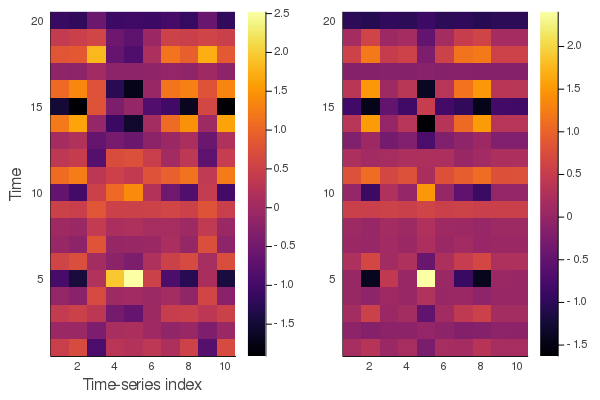

In [21]:
heatmap(A, layout=2, ylabel="Time", xlabel="Time-series index"); heatmap!(Ah, subplot=2)

How well does our decomposition approximate the original time series?

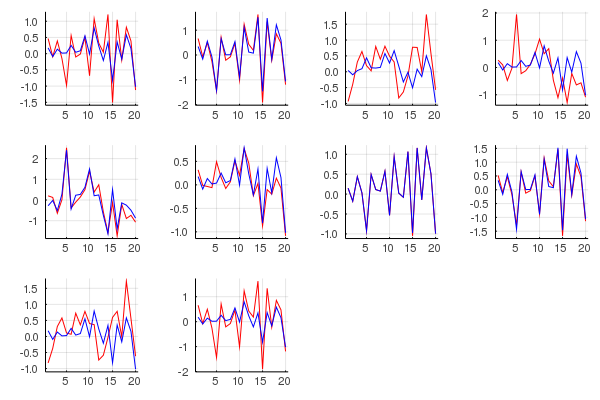

In [22]:
plot(A, c=:red, layout=10); plot!(Ah, c=:blue, legend=false)

Just for fun, let's look at the basis functions

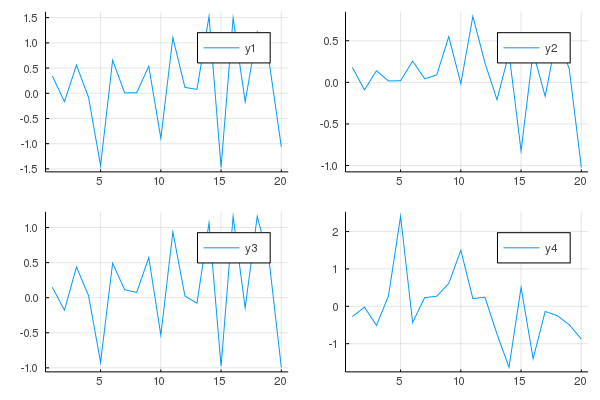

In [23]:
plot(Wh, layout=size(Wh,2))

Now, let's see if the resulting $H$ is sparse

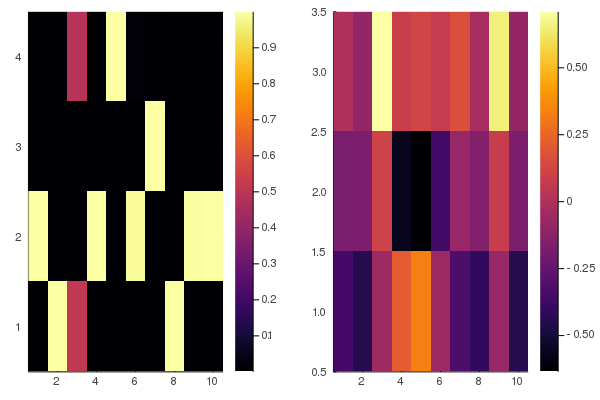

In [24]:
plot(heatmap(softmax(Hh)), heatmap(Hsvd))

To see if we have used too many basis functions, we see if there are strong correlations between them.

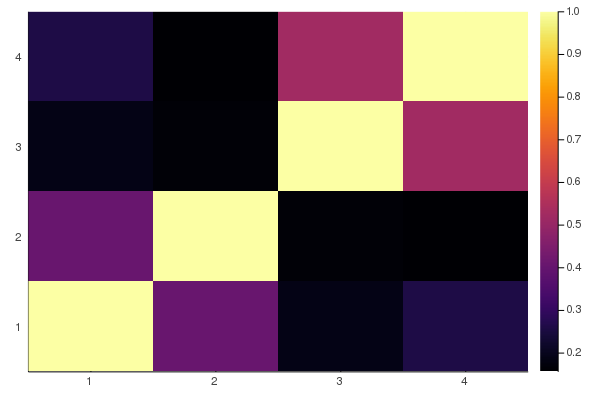

In [19]:
heatmap(abs.(cor(Hh')))